In [2]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DEBUG = False

def debug(str):
  if DEBUG:
    print(str)

In [5]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
#from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-5-1efe6330c8cc>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [6]:
def load_document(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [7]:
def create_image_caption_dictionary(filename):
  captions = load_document(filename)
  splited_captions = captions.split('\n')
  debug(captions.split('\n'))
  descriptions = {}
  for i in splited_captions[1:-1]:
    i = str(i)
    debug(i)
    image, caption = i.split(',',1)
    if image not in descriptions:
      descriptions[image] = [caption]
    else:
      descriptions[image].append(caption)
  return descriptions

In [8]:
descriptions = create_image_caption_dictionary('/content/drive/MyDrive/CV Project - Image caption generator/archive (1)/captions.txt')

def printDictionary(dictionary, prnt = False):
  if prnt:
    keys = list(dictionary.keys())
    print(keys)
    for i in keys:
      print("Image: {}, captions: {}".format(i, descriptions.get(i)))
  pass

printDictionary(descriptions, prnt = False) #set prnt to true to visulize the pre processed text data for the image captions.

In [9]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

cln_descriptions = cleaning_text(descriptions)
debug(cln_descriptions)

In [10]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

vocabulary = text_vocabulary(cln_descriptions)
debug(vocabulary)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [11]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

save_descriptions(cln_descriptions, "/content/drive/MyDrive/CV Project - Image caption generator/descriptions.txt")

# Feature Extraction using transfer learning - XCEPTION

In [12]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features

dataset_images = "/content/drive/MyDrive/CV Project - Image caption generator/archive (1)/Images"
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

83683744/83683744 [==============================] - 5s 0us/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-f628989e7b72>", line 18, in <module>
    features = extract_features(dataset_images)
  File "<ipython-input-12-f628989e7b72>", line 4, in extract_features
    for img in tqdm(os.listdir(directory)):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinner

KeyboardInterrupt: ignored

In [24]:
features = load(open("/content/drive/MyDrive/CV Project - Image caption generator/features.p","rb"))

In [25]:
def load_photos(filename):
    file = load_document(filename)
    photos = file.split("\n")[:-1]
    return photos

In [26]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_document(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [27]:
def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/CV Project - Image caption generator/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [28]:

filename = "/content/drive/MyDrive/CV Project - Image caption generator/Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/CV Project - Image caption generator/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [29]:
print("The list of training images are: {}".format(train_imgs))
print("The dictionary of training images with captions: {}".format(train_descriptions))

The list of training images are: ['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg', '218342358_1755a9cce1.jpg', '2501968935_02f2cd8079.jpg', '2699342860_5288e203ea.jpg', '2638369467_8fc251595b.jpg', '2926786902_815a99a154.jpg', '2851304910_b5721199bc.jpg', '3423802527_94bd2b23b0.jpg', '3356369156_074750c6cc.jpg', '2294598473_40637b5c04.jpg', '1191338263_a4fa073154.jpg', '2380765956_6313d8cae3.jpg', '3197891333_b1b0fd1702.jpg', '3119887967_271a097464.jpg', '2276499757_b44dc6f8ce.jpg', '2506892928_7e79bec613.jpg', '2187222896_c206d63396.jpg', '2826769554_85c90864c9.jpg', '3097196395_ec06075389.jpg', '3603116579_4a28a932e2.jpg', '3339263085_6db9fd0981.jpg', '2532262109_87429a2cae.jpg', '2076906555_c20dc082db.jpg', '2502007071_82a8c639cf.jpg', '3113769557_9edbb8275c.jpg', '3325974730_3ee192e4ff.jpg', '1655781989_b15ab4cbff.jpg', '1662261486_db967930de.jpg', '2410562803_56ec09f41c.jpg', '2469498117

In [30]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [31]:
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [32]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size of the tokens: {}".format(vocab_size))

Vocabulary size of the tokens: 7577


In [33]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
print("Maximum length of the descrption to find the parameter for RNN: {}".format(max_length))

Maximum length of the descrption to find the parameter for RNN: 32


In [34]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [35]:

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [36]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [37]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

<ipython-input-37-7600b5951421>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 570s 95ms/step - loss: 2.7787


# Testing the model

1/1 [==============================] - 1s 775ms/step



start brown dog is running through the grass end


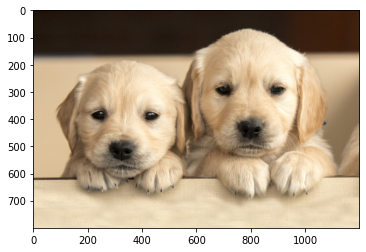

In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.applications.xception import Xception, preprocess_input
from pickle import dump, load

"""
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args())
img_path = args['image']
"""

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

img_path = "/content/dogs.jpg"
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)